In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

In [9]:
# 데이터 경로 변수
ROOT_PATH = os.path.expanduser("~"  + os.getlogin() + "\Downloads")
TRAIN_PATH = ROOT_PATH + '/Data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/Data/val/*/*'
TEST_PATH = ROOT_PATH + '/Data/test/*/*'

In [90]:
# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

C:\Users\uilov\Downloads
5216
624
16


In [91]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

In [92]:
# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")


train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)


TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

4185
1047
Normal image path
C:\Users\uilov\Downloads\Data\train\NORMAL\NORMAL2-IM-0707-0001.jpeg
Pneumonia image path
C:\Users\uilov\Downloads\Data\train\PNEUMONIA\person610_bacteria_2475.jpeg
Normal images count in training set: 1072
Pneumonia images count in training set: 3113
Training images count: 4185
Validating images count: 1047


In [14]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [41]:
for element in train_list_ds:
    print(element.numpy())

b'C:\\Users\\uilov\\Downloads\\Data\\train\\NORMAL\\NORMAL2-IM-0707-0001.jpeg'
b'C:\\Users\\uilov\\Downloads\\Data\\train\\PNEUMONIA\\person1310_bacteria_3301.jpeg'
b'C:\\Users\\uilov\\Downloads\\Data\\train\\PNEUMONIA\\person1372_bacteria_3501.jpeg'
b'C:\\Users\\uilov\\Downloads\\Data\\train\\PNEUMONIA\\person581_bacteria_2400.jpeg'
b'C:\\Users\\uilov\\Downloads\\Data\\train\\NORMAL\\IM-0387-0001.jpeg'
b'C:\\Users\\uilov\\Downloads\\Data\\train\\PNEUMONIA\\person1541_virus_2681.jpeg'
b'C:\\Users\\uilov\\Downloads\\Data\\train\\NORMAL\\NORMAL2-IM-0971-0001-0002.jpeg'
b'C:\\Users\\uilov\\Downloads\\Data\\train\\PNEUMONIA\\person502_bacteria_2118.jpeg'
b'C:\\Users\\uilov\\Downloads\\Data\\train\\NORMAL\\NORMAL2-IM-1038-0001.jpeg'
b'C:\\Users\\uilov\\Downloads\\Data\\train\\NORMAL\\IM-0629-0001-0002.jpeg'
b'C:\\Users\\uilov\\Downloads\\Data\\train\\PNEUMONIA\\person1868_bacteria_4743.jpeg'
b'C:\\Users\\uilov\\Downloads\\Data\\train\\PNEUMONIA\\person646_bacteria_2538.jpeg'
b'C:\\Users\\ui

In [15]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

In [96]:
# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label


train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())


test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)


def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

Image shape:  (180, 180, 3)
Label:  False
624


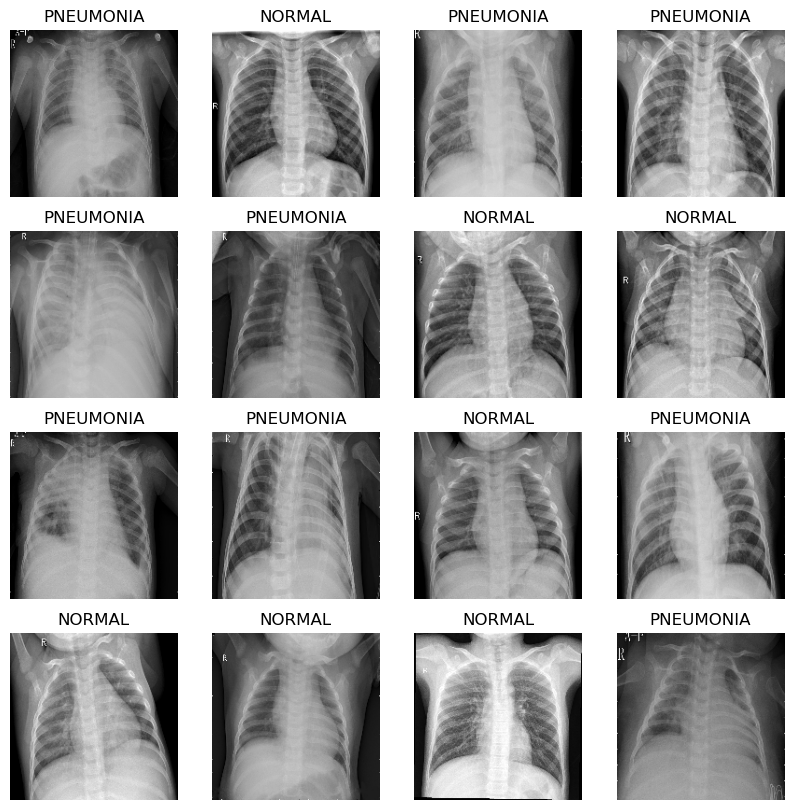

In [100]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [20]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [23]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )


with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )


Epoch 1/10
261/261 [==============================] - 56s 174ms/step - loss: 0.4193 - accuracy: 0.8008 - precision: 0.9501 - recall: 0.7728 - val_loss: 0.6725 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 42s 162ms/step - loss: 0.2399 - accuracy: 0.9076 - precision: 0.9674 - recall: 0.9063 - val_loss: 1.0526 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 40s 155ms/step - loss: 0.2028 - accuracy: 0.9212 - precision: 0.9760 - recall: 0.9167 - val_loss: 0.1401 - val_accuracy: 0.9394 - val_precision: 0.9250 - val_recall: 0.9987
Epoch 4/10
261/261 [==============================] - 41s 157ms/step - loss: 0.1846 - accuracy: 0.9351 - precision: 0.9791 - recall: 0.9327 - val_loss: 0.0910 - val_accuracy: 0.9644 - val_precision: 0.9609 - val_recall: 0.9922
Epoch 5/10
261/261 [==============================] - 41s 158ms/step - loss: 0.1563 - accura

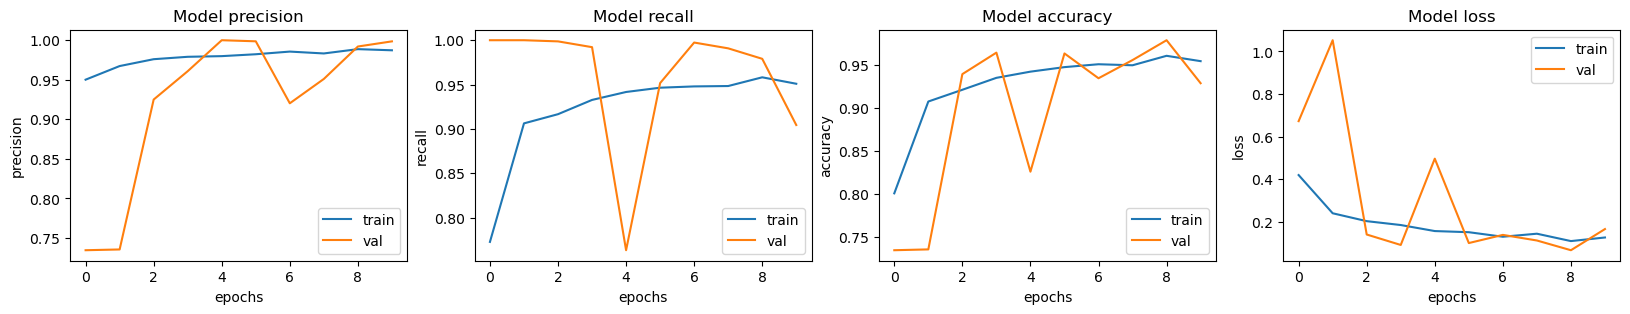

In [79]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [80]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 134ms/step - loss: 0.3087 - accuracy: 0.8798 - precision: 0.8706 - recall: 0.9487
Loss: 0.3087037205696106,
Accuracy: 0.879807710647583,
Precision: 0.8705882430076599,
Recall: 0.9487179517745972


In [81]:
import tensorflow
print(tensorflow.__version__)

2.10.0


In [101]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label



def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

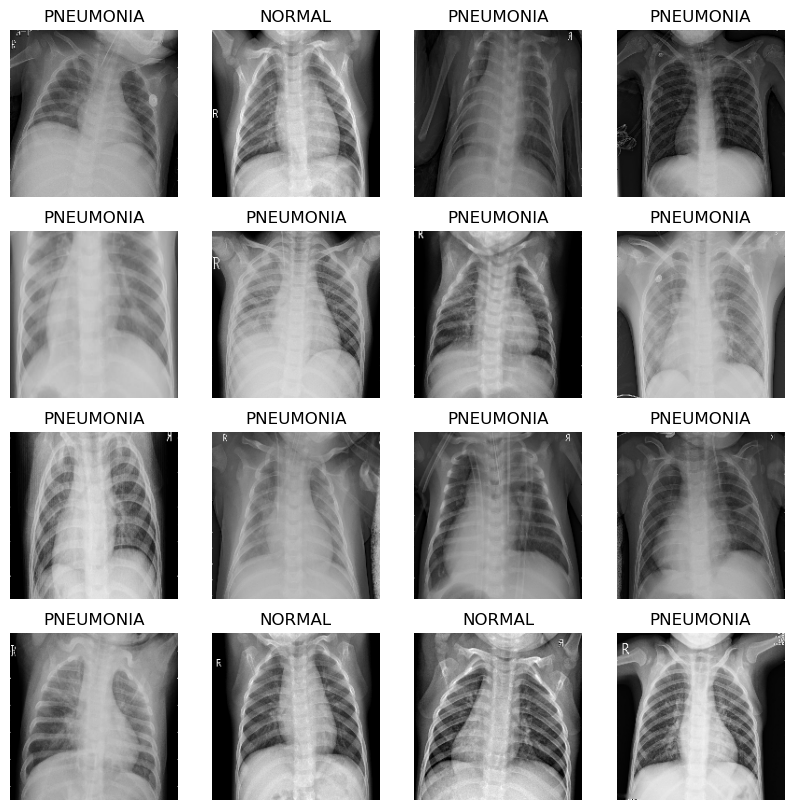

In [102]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [241]:
# 입력파트
INPUT = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = tf.keras.layers.Conv2D(64, (5, 5), strides=2, padding="same")(INPUT)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding="same")(x)

for filter_num in [64, 128, 256, 512] :
    stride = 2 - int(filter_num == 64)
    residual = Conv2D(filter_num, (1, 1), strides=stride)(x)
    
    for _ in range(2):
        x = tf.keras.layers.Conv2D(filter_num, (3, 3), strides=stride, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        stride = 1

    x = tf.add(x, residual)
    x = tf.keras.layers.Activation('relu')(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
OUTPUT = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=INPUT, outputs=OUTPUT)
model2.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_87 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_429 (Conv2D)            (None, 90, 90, 64)   4864        ['input_87[0][0]']               
                                                                                                  
 batch_normalization_328 (Batch  (None, 90, 90, 64)  256         ['conv2d_429[0][0]']             
 Normalization)                                                                                   
                                                                                           

In [223]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [242]:
with tf.device('/GPU:0'):

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
        loss='binary_crossentropy',
        metrics=METRICS,
    )


with tf.device('/GPU:0'):
    history2 = model2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=100,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping]
    )

Epoch 1/100


261/261 [==============================] - 49s 157ms/step - loss: 0.3356 - accuracy: 0.8740 - precision: 0.9527 - recall: 0.8742 - val_loss: 9.5147 - val_accuracy: 0.7337 - val_precision: 0.7351 - val_recall: 0.9974
Epoch 2/100
261/261 [==============================] - 39s 149ms/step - loss: 0.2404 - accuracy: 0.9057 - precision: 0.9669 - recall: 0.9041 - val_loss: 2.5696 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/100
261/261 [==============================] - 39s 151ms/step - loss: 0.2045 - accuracy: 0.9174 - precision: 0.9745 - recall: 0.9126 - val_loss: 0.3248 - val_accuracy: 0.8625 - val_precision: 0.9968 - val_recall: 0.8162
Epoch 4/100
261/261 [==============================] - 41s 158ms/step - loss: 0.1828 - accuracy: 0.9260 - precision: 0.9756 - recall: 0.9238 - val_loss: 1.5333 - val_accuracy: 0.3837 - val_precision: 1.0000 - val_recall: 0.1610
Epoch 5/100
261/261 [==============================] - 47s 179ms/step - loss: 0.1763 - accuracy: 0.9

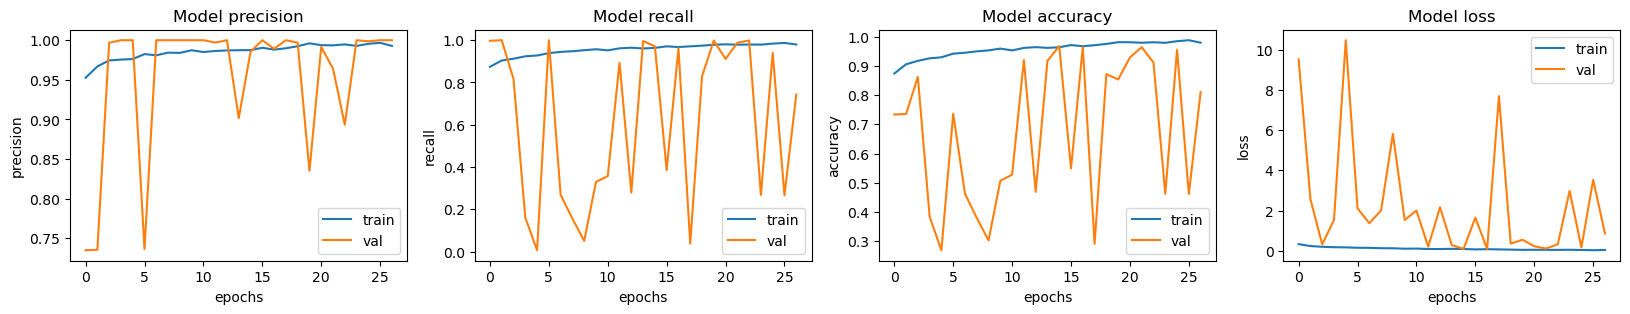

In [243]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [244]:
model2.evaluate(test_ds)

39/39 [==============================] - 4s 104ms/step - loss: 0.7248 - accuracy: 0.8093 - precision: 0.7726 - recall: 0.9846


[0.7247812151908875, 0.8092948794364929, 0.772635817527771, 0.9846153855323792]

In [246]:
model2.save(ROOT_PATH)

INFO:tensorflow:Assets written to: C:\Users\uilov\Downloads\assets


INFO:tensorflow:Assets written to: C:\Users\uilov\Downloads\assets


# keep
callback함수를 통해 높은 에폭스에 대한 대응책을 마련해두었다. Dropout레이어를 추가하고, 일반적인 resnet18이 224인 것을 감안 필터 크기 7을 5로 줄여 구현해보았다.
비록 precision이 77%이지만 재현율이 98%에 가까워 의료모델 판단에 괜찮은 모델이라 생각한다. 물론 생각외로 데이터가 적었다.

# problem
처음 Resnet18 구조를 그림만 보고는 제대로 이해하기 어려워 실제 코드로 구현된 모델을 찾기 위해 엄청 노력했는데 실제로 너무 찾기 힘들었다.(실제 메인퀘스트 시간 중이었다면 못찾았을 것 같다..) 정확히는 skip-connection을 하기 위해 add가 되어야 하는데 어떠한 기준으로 하는 지 명확한 기준이 없어보여 힘들었다.

# try
최대한 모델을 찾고 구현해보려 노력해보았고, 결국 chat=gpt4.0이 클래스로 구현된 것을 보여주었고 그것을 따라 functional 구조로 구현한 뒤 드롭아웃과 학습률을 조정하여 과적합을 배제하려 노력하였다. 다만 에폭스 수만 늘리고 early stopping으로 과적합을 방지하되 validation 데이터에도 적합한 모델을 찾으려 강구하였다.
